In [1]:
import numpy as np
import time
%tensorflow_version 1.14
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from matplotlib import pyplot as plt

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
latent_dim = 100

img_rows, img_cols = 28, 28
img_channels = 1
(x_train, _), (_, _) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_channels)
x_train = x_train.astype('float32')
x_train /= 255

11493376/11490434 [==============================] - 1s 0us/step


## Générateur

In [0]:
def gen(): 
    dropout = 0.4
    depth = 256 # 64+64+64+64
    dim = 7
    
    model = Sequential()
    # In: 100
    # Out: dim x dim x depth
    model.add(Dense(dim*dim*depth, input_dim=latent_dim))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))
    model.add(Reshape((dim, dim, depth)))
    model.add(Dropout(dropout))

    # In: dim x dim x depth
    # Out: 2*dim x 2*dim x depth/2
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))

    model.add(UpSampling2D())
    model.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))

    # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
    model.add(Conv2DTranspose(1, 5, padding='same'))
    model.add(Activation('sigmoid'))
    
    return model

## Discriminant

In [0]:
# (W−F+2P)/S+1
def disc():
    depth = 64
    dropout = 0.4
    input_shape = (img_rows, img_cols, img_channels)
    
    model = Sequential()
    # In: 28 x 28 x 1, depth = 1
    # Out: 14 x 14 x 1, depth=64
    model.add(Conv2D(depth, 5, strides=2, input_shape=input_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(depth*2, 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(depth*4, 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(depth*8, 5, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    # Out: probabilite
    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

# Modèle de GAN

## Modèle discriminant


In [5]:
discriminant = disc()
discriminant.compile(loss='binary_crossentropy', 
                      optimizer=Adam(0.00007, 0.5), 
                      metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
generateur = gen()

## Modèle compétitif


In [0]:
def modele_competitif():
    model = Sequential()
    model.add(generateur)
    discriminant.trainable = False
    model.add(discriminant)
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(0.00007, 0.5), 
                  metrics=['accuracy'])
    discriminant.trainable = True
    return model

In [0]:
modele_comp = modele_competitif()

## Entraînement

In [0]:
def plot_images(saveToFile=False, fake=True, samples=16, noise=None, epoch=0):
    filename = 'mnist.png'
    if fake:
        if noise is None:
            noise = np.random.uniform(-1.0, 1.0, size=[samples, latent_dim])
        else:
            filename = "mnist_%d.png" % epoch
        images = generateur.predict(noise)
    else:
        i = np.random.randint(0, x_train.shape[0], samples)
        images = x_train[i, :, :, :]

    plt.figure(figsize=(10,10))
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [img_rows, img_cols])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    if saveToFile:
        plt.savefig(filename)
        plt.close('all')
    else:
        plt.show()

In [0]:
def train(train_epochs=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_dim])
        for epoch in range(train_epochs):
            
            
            # sélection d'une moitié aléatoire d'images
            images_train = x_train[np.random.randint(0, x_train.shape[0], size=batch_size), :, :, :]
            
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_dim])
            images_fake = generateur.predict(noise)
            
            # entraîner le discriminant (1 = vraie, 0 = fausse)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = discriminant.train_on_batch(x, y)

            # ---------------------
            #  Entraînement générateur
            # ---------------------
            
            # entraîner le générateur
            y = np.ones([batch_size, 1])
            a_loss = modele_comp.train_on_batch(noise, y)
            
            log_msg = "%d: [D loss: %f, acc: %f]" % (epoch, d_loss[0], d_loss[1])
            log_msg = "%s  [A loss: %f, acc: %f]" % (log_msg, a_loss[0], a_loss[1])
            print(log_msg)
            if save_interval>0:
                if (epoch+1)%save_interval==0:
                    plot_images(saveToFile=True, samples=noise_input.shape[0],
                                noise=noise_input, epoch=(epoch+1))

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [D loss: 0.692337, acc: 0.542969]  [A loss: 0.731880, acc: 0.000000]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
15002: [D loss: 0.660974, acc: 0.605469]  [A loss: 0.791175, acc: 0.375000]
15003: [D loss: 0.644022, acc: 0.646484]  [A loss: 0.800248, acc: 0.328125]
15004: [D loss: 0.673708, acc: 0.564453]  [A loss: 0.853934, acc: 0.261719]
15005: [D loss: 0.669511, acc: 0.572266]  [A loss: 0.822437, acc: 0.304688]
15006: [D loss: 0.656841, acc: 0.605469]  [A loss: 0.785374, acc: 0.390625]
15007: [D loss: 0.675879, acc: 0.566406]  [A loss: 0.778802, acc: 0.433594]
15008: [D loss: 0.676891, acc: 0.578125]  [A loss: 0.825697, acc: 0.347656]
15009: [D loss: 0.672683, acc: 0.593750]  [A loss: 0.836442, acc: 0.316406]
15010: [D loss: 0.679448, acc: 0.568359]  [A loss: 0.795215, acc: 0.378906]
15011: [D loss: 0.680769, acc: 0.564453]  [A loss: 0.731608, acc: 0.453125]
15012: [D loss: 0.674569, acc: 0.578125]  [A loss: 0.823418, acc: 0.363281]
15013: [D loss: 0.659376, acc: 0.601562]  [A loss: 0.828001, acc: 0.312500]
15014: [D loss: 0.683481, acc: 0.5683

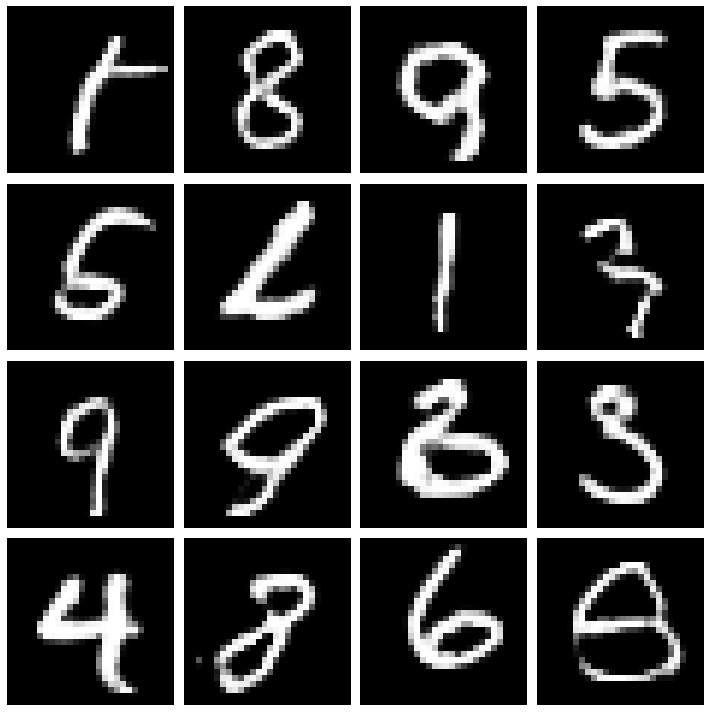

In [12]:
train(train_epochs=20000, batch_size=256, save_interval=1000) 
plot_images(fake=True)
plot_images(fake=False, saveToFile=True)